# **Actividad #1 Corte #2**

In [ ]:
!pip install ta
!pip install scikit-learn

In [4]:
import pandas as pd
from scipy.stats import shapiro
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest
import datetime  # Usar la biblioteca estándar datetime
plt.rcParams['text.usetex'] = False  # Desactivar el uso de LaTeX
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, close, subplots, title
import requests
import io
from statsmodels.tsa import stattools
import seaborn as sns
# from pmdarima import arima
# from pmdarima import datasets
# from pmdarima import utils
import warnings
import ta
from ta import trend
from statsmodels.tsa import seasonal
import os
import pickle
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install yfinance

In [ ]:
# Importa el paquete yfinance
import yfinance as yfin

# Define el ticker y el rango de fechas
ticker = "USDT-CNY"  
start_date = "2017-12-01"
end_date = "2024-12-09"

# Obtén los datos del ticker
data = yfin.download(ticker, start=start_date, end=end_date)

# Guarda los datos en un archivo CSV
data.to_csv('XRP.csv')

# Muestra los primeros y últimos registros
print(data.head())
print(data.tail())


## **Procesamiento de Datos**

Se importan las librerias necesarias para modelar la serie de tiempo de la criptomonedas **XRP-USD**

In [67]:
data = pd.read_csv('XRP.csv', parse_dates= ["Date"], index_col= "Date")
print('No. de filas, columnas:', data.shape)
data.head()

No. de filas, columnas: (2484, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,6.656585,6.735959,6.561035,6.678382,6.678382,4956280114
2017-12-02,6.672893,6.724612,6.584673,6.611412,6.611412,4496985421
2017-12-03,6.620446,6.809068,6.516611,6.618065,6.618065,6261513808
2017-12-04,6.629903,6.709969,6.561663,6.642790,6.642790,4424533541
2017-12-05,6.641731,6.673897,6.588879,6.630036,6.630036,5387203976


In [68]:
data.info()# Información relevante de la data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2484 entries, 2017-12-01 to 2024-09-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2484 non-null   float64
 1   High       2484 non-null   float64
 2   Low        2484 non-null   float64
 3   Close      2484 non-null   float64
 4   Adj Close  2484 non-null   float64
 5   Volume     2484 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 135.8 KB


## **Análisis exploratorio de Series de Tiempo**

**Resumen estadístico**

In [69]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2.484000e+03
mean,6.827946,6.859062,6.802363,6.828162,6.828162,2.828140e+11
std,0.301374,0.305613,0.305399,0.301417,0.301417,2.304051e+11
min,6.149873,6.290013,5.811755,6.214656,6.214656,4.424534e+09
25%,6.531684,6.545328,6.504769,6.529469,6.529469,1.196599e+11
50%,6.874025,6.912972,6.832410,6.873450,6.873450,2.519973e+11
75%,7.096591,7.128866,7.069874,7.096821,7.096821,3.961512e+11
max,7.340966,7.621492,7.344603,7.406279,7.406279,1.795799e+12


**Gráfico de la serie, autocorrelación y autocorrelación parcial**

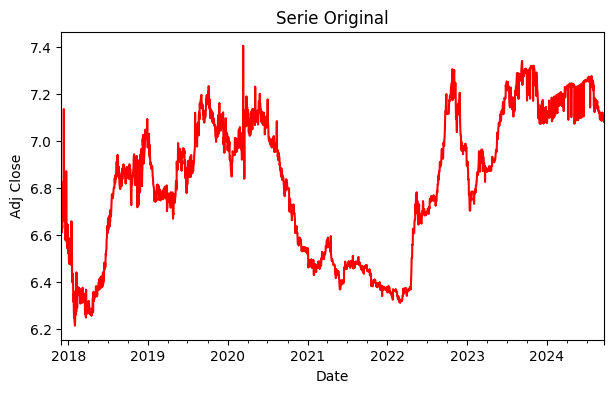

In [70]:
if data['Adj Close'].isnull().sum() > 0:
    data['Adj Close'] = data['Adj Close'].fillna(method='ffill')


plt.rcParams.update({'figure.figsize': (7, 4)})
plt.rcParams['text.usetex'] = False  # Desactivar el uso de LaTeX

nlag = 50

# Serie original
data['Adj Close'].plot(color='r')
plt.title('Serie Original')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

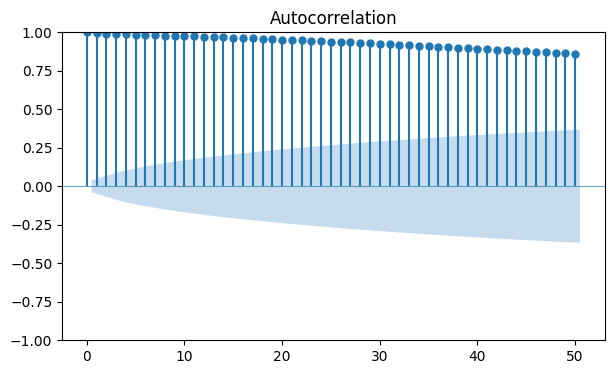

In [71]:
# Autocorrelación y autocorrelación parcial
plot_acf(data['Adj Close'], lags=nlag, linewidth=0.5)  # Autocorrelación
plt.show()

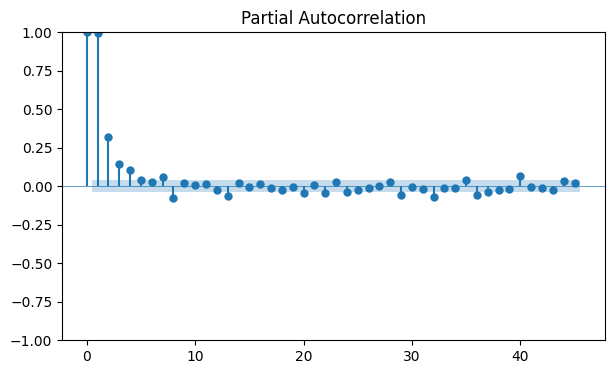

In [72]:
plot_pacf(data['Adj Close'], lags=45, linewidth=0.5)  # Autocorrelación Parcial
plt.show()

Las figuras anteriores revelan:
* El conjunto de datos de **USDT** muestra claramente una señal no estacionaria con un comportamiento que crece y decrece en cierto lapsus.

La **No estacionariedad** también puede comprobarse evaluando la media y la varianza en distintos.
* La diferencia en la media y la varianza valida la hipótesis de no estacionariedad. Por ejemplo, dividimos el conjunto de datos de **USDT** en dos muestras, y evaluamos la media y la varianza para cada muestra del siguiente modo:

In [73]:
Mean1, Mean2 =data.iloc[:100].Close.mean(), data.iloc[100:].Close.mean()
Var1, Var2 = data.iloc[:100].Close.var(), data.iloc[100:].Close.var()
print('mean1=%f, mean2=%f' % (Mean1, Mean2))
print('variance1=%f, variance2=%f' % (Var1, Var2))

mean1=6.479882, mean2=6.842771
variance1=0.030246, variance2=0.088105


La media y la varianza evaluadas para ambas muestras revelan una diferencia
significativa en los valores de la media y la varianza, lo que sugiere que los
datos no son estacionarios. Otra forma de evaluar la no estacionariedad es utilizar pruebas estadísticas como la prueba de **Dickey-Fuller (ADF)**.

Es una prueba de raíz unitaria que evalúa la fuerza de la tendencia en una componente de la serie temporal

**Método Análitico (Prueba  Dickey Fuller aumentada ADF)**

Es una prueba de raíz única que detecta estadísticamente la presencia de conducta tendencial estocástica en las series temporales de las variables mediante un contraste de hipótesis.


En presencia de una autocorrelación, es necesario diferenciar la serie del precio de cierre de USDT. por tal motivo las hipótesis a plantear son:

 **H0 : ρ =0** La serie tiene una raíz unitaria y no es estacionaria.

 **H1 : ρ <0** La serie no tiene una raíz unitaria y es estacionaria.

En otras palabras, la hipótesis nula es la presencia de la raíz unitaria o la no estacionariedad mientras que la hipótesis alternativa sugiere la estacionariedad de los datos.

In [74]:
adf_result = adfuller(data["Adj Close"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])


ADF Statistic: -1.477959
p-value: 0.544385


**Valor p** se define como la probabilidad de que un valor estadístico calculado sea posible dada una hipótesis nula cierta.

* Idealmente, un valor más negativo del estadístico ADF representará una señal estacionaria, en este caso de **Binance** (-1.131586), podria **NO** ser  **Estacionaria**



* Dado que **𝑝-value**= 0.549110 > 0.05. de Adfuller es mayor que un determinado valor alfa especificado (5%, nivel de significación o intervalo de confianza del 95%), No se rechaza la hipótesis nula (𝐻𝑜) es decir, la serie temporal No es estacionaria.

**Descomposición de la serie**

Intentamos descomponer la serie temporal y, en consecuencia, estacionarla utilizando la función
_seasonal.seasonal decompose de la API statsmodels.tsa._ Intentemos primero el **modelo aditivo para la descomposición**

**Modelo Aditivo**

In [75]:
decompose_model = seasonal.seasonal_decompose(data["Adj Close"].tolist(),
period=20, model='additive')

El argumento **period** en el seasonal.seasonal_decompose es la periodicidad del comportamiento estacional y la serie temporal original.

Los componentes de tendencia-ciclo, estacional y residual de la serie temporal
descompuesta son accesibles a través de los atributos del objeto decompose_model
devuelto por el seasonal.seasonal_decompose.

Estos componentes se pueden obtener a partir de los siguientes atributos del decompose_model:
 * decompose_model.trend: Componente de ciclo de tendencia
 * decompose_model.seasonal: Componente estacional
 * decompose_model.resid: Variaciones irregulares (residuos)


Text(0.5, 1.0, 'Variaciones irregulares del precio de cierre USDT')

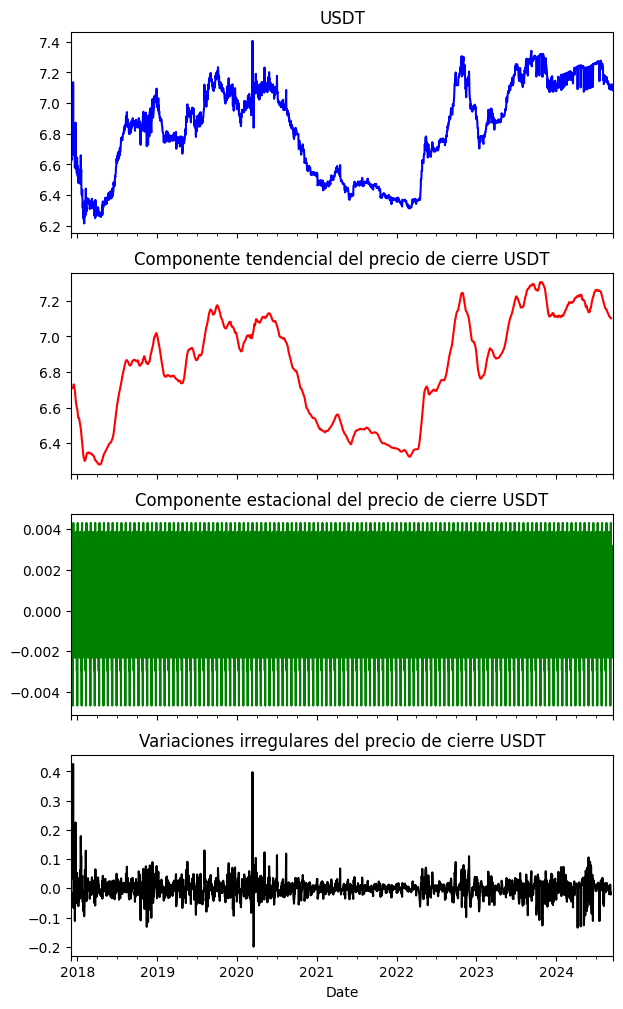

In [76]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)

data['Adj Close'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('USDT')

pd.Series(data=decompose_model.trend, index=data.index).plot(color='r',
linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial del precio de cierre USDT')

pd.Series(data=decompose_model.seasonal, index=data.index).plot(color='g',
linestyle='-', ax=axarr[2])
axarr[2].set_title('Componente estacional del precio de cierre USDT')

pd.Series(data=decompose_model.resid, index=data.index).plot(color='k',
linestyle='-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares del precio de cierre USDT')

In [77]:
adf_result = stattools.adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]],autolag='AIC')
print('p-val de la prueba ADF sobre variaciones irregulares en los datos del precio BNB:',
adf_result[1])

p-val de la prueba ADF sobre variaciones irregulares en los datos del precio BNB: 5.387689990518867e-26


Ahora ejecutamos la prueba ADF sobre los residuos del modelo aditivo y obtenemos un
valor de **5.487256088756904e-26**, que es mucho menor que el obtenido con la serie temporal original.

**Prueba de Normalidad**

En la figura siguiente se muestra el gráfico qqplot para visualizar la normalidad del conjunto valores irregulares de datos
USDT.

**Método gráfico**

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\graphics\gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


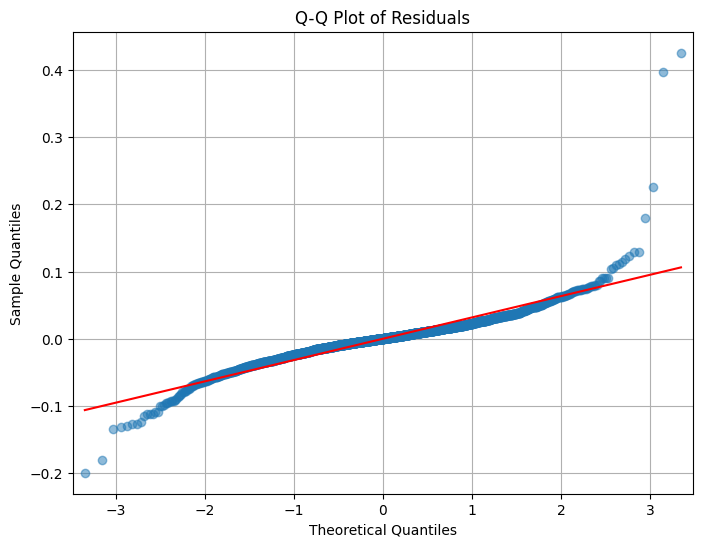

In [78]:
decompose_model = seasonal.seasonal_decompose(data['Adj Close'], period=20, model='additive')

plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)
plt.show()

**Método análitico**

La normalidad también puede evaluarse mediante la prueba de **Shapiro-Wilk** para la presencia de una normalidad se plantean las siguientes hipótesis

 **H0 :  La muestra parece provenir de una distribución normal**

 **H1 : La muestra no parece provenir de una distribución normal**

In [79]:
resid_clean = decompose_model.resid.replace([np.inf, -np.inf], np.nan).dropna()

# Realizar la prueba de Shapiro-Wilk
stat, p = shapiro(resid_clean)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretación de los resultados
alpha = 0.05
if p > alpha:
    print('La muestra parece normal (no se rechaza H0)')
else:
    print('La muestra no parece normal (se rechaza H0)')

Statistics=0.870, p=0.000
La muestra no parece normal (se rechaza H0)


## **Modelo ARIMA**

El objetivo del análisis de series temporales es desarrollar un modelo matemático que
pueda explicar el comportamiento observado de una serie temporal y posiblemente
predecir su estado futuro.

## **Diferenciación**

Luego que se comprobó que los datos no son estacionarios se realiza la diferenciación, la cual, ayudará a que la señal sea estacionaria.
Tracemos las series temporales originales y las de primera diferencia

In [ ]:
%pip install --upgrade numpy
%pip install --upgrade pmdarima


In [ ]:
%pip install --upgrade scipy Cython pandas


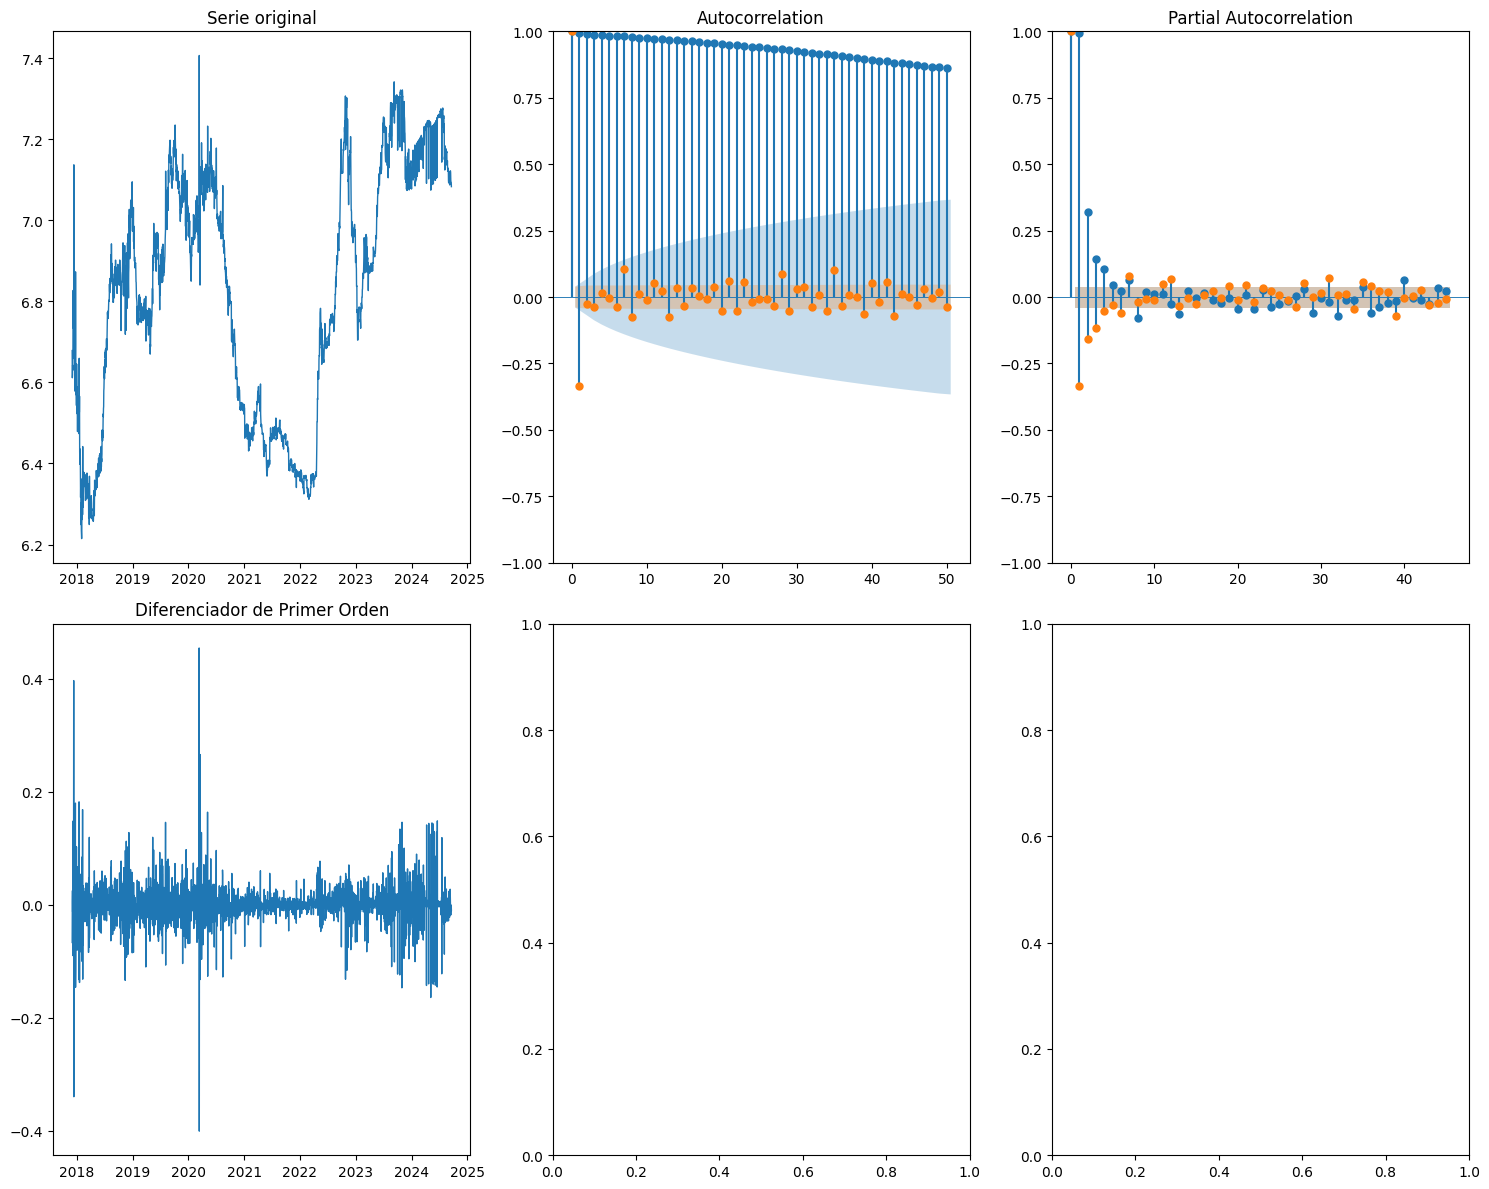

In [80]:
# Modelo Arima

plt.rcParams.update({'text.usetex': False})

plt.rcParams.update({'figure.figsize': (15, 12)})
fig, axes = plt.subplots(2, 3, sharex=False)
nlag = 50

axes[0, 0].plot(data["Close"], linewidth=1)
axes[0, 0].set_title('Serie original')
plot_acf(data["Close"], lags=nlag, linewidth=0.5, ax=axes[0, 1])
plot_pacf(data["Close"], lags=45, linewidth=0.5, ax=axes[0, 2]);

# Diferenciador de Primer Orden
axes[1, 0].plot(data["Close"].diff(), linewidth=1)
axes[1, 0].set_title('Diferenciador de Primer Orden')
plot_acf(data["Close"].diff().dropna(), lags=nlag, linewidth=0.5, ax=axes[0, 1])
plot_pacf(data["Close"].diff().dropna(), lags=45, linewidth=0.5, ax=axes[0, 2])

# Diferenciador de Segundo Orden
# axes[2, 0].plot(data["Close"].diff().diff(), linewidth=1)
# axes[2, 0].set_title('Diferenciador de Segundo Orden')
# plot_acf(data["Close"].diff().diff().dropna(), lags=40, linewidth=0.5, ax=axes[1, 1])
# plot_pacf(data["Close"].diff().diff().dropna(), lags=35, linewidth=0.5, ax=axes[1, 2])

plt.tight_layout()
plt.show()

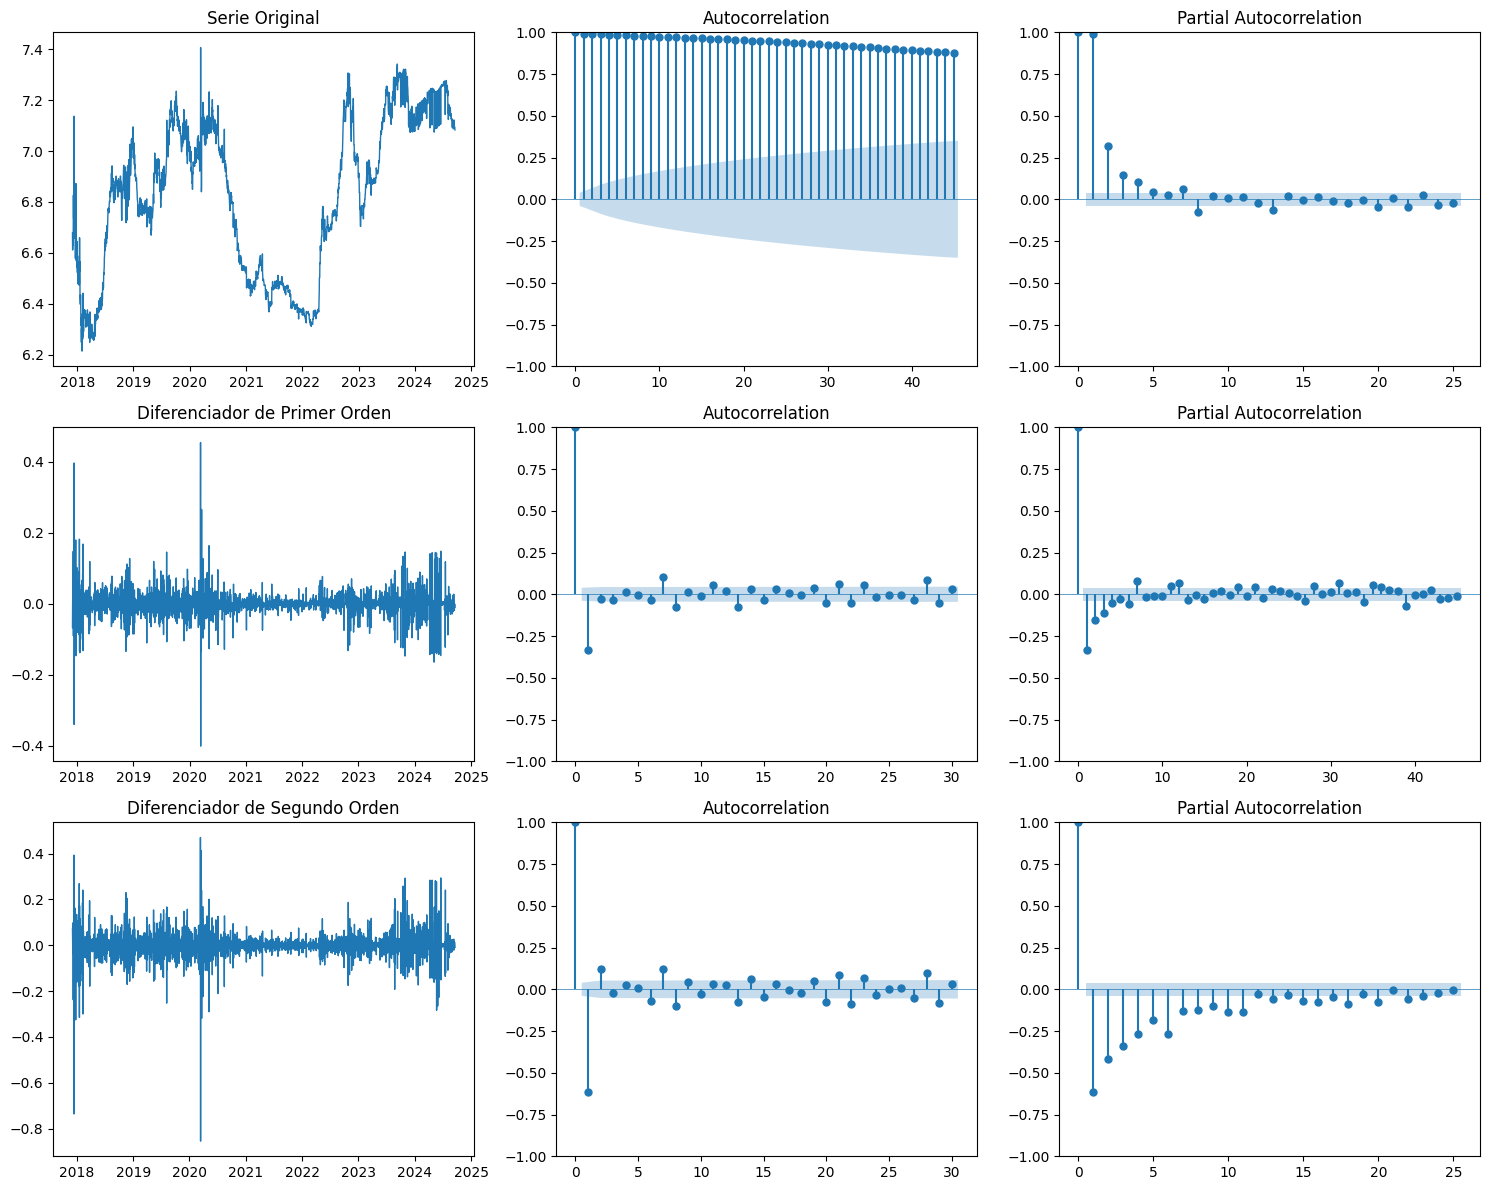

In [81]:
plt.rcParams.update({'text.usetex': False})
plt.rcParams.update({'figure.figsize': (15, 12)})

fig, axes = plt.subplots(3, 3, sharex=False)
nlag = 30

# Original series
axes[0, 0].plot(data["Close"], linewidth=1)
axes[0, 0].set_title('Serie Original')
plot_acf(data["Close"], lags=45, linewidth=0.5, ax=axes[0, 1])
plot_pacf(data["Close"], lags=25, linewidth=0.5, ax=axes[0, 2])

# Diferenciador de Primer Orden
axes[1, 0].plot(data["Close"].diff(), linewidth=1)
axes[1, 0].set_title('Diferenciador de Primer Orden')
plot_acf(data["Close"].diff().dropna(), lags=nlag, linewidth=0.5, ax=axes[1, 1])
plot_pacf(data["Close"].diff().dropna(), lags=45, linewidth=0.5, ax=axes[1, 2])

# Diferenciador de Segundo Orden
axes[2, 0].plot(data["Close"].diff().diff(), linewidth=1)
axes[2, 0].set_title('Diferenciador de Segundo Orden')
plot_acf(data["Close"].diff().diff().dropna(), lags=nlag, linewidth=0.5, ax=axes[2, 1])
plot_pacf(data["Close"].diff().diff().dropna(), lags=25, linewidth=0.5, ax=axes[2, 2])

plt.tight_layout()
plt.show()

De acuerdo con los graficos anteriores, se puede observar la estacionariedad.

 **Prueba de Dickey-Fuller**

In [82]:
adjclose_diff = data["Adj Close"].diff().dropna()
adf_result2 = adfuller(adjclose_diff)
print('ADF Statistic: %f' % adf_result2[0])
print('p-value: %f' % adf_result2[1])

ADF Statistic: -8.538949
p-value: 0.000000


## **Criterios AIC, BIC y HQIC**
Los criterios de información de Akaike (AIC), Bayesiano (BIC) y de Hannan-Quinn (HQIC) utilizan el método de estimación de máxima verosimilitud (log-verosimilitud) de los modelos como medida de ajuste. Estas medidas buscan valores bajos para indicar un mejor ajuste del modelo a los datos.

In [83]:
n_data = len(data["Adj Close"])  # Usa el nombre exacto de la columna con corchetes
n_test = 30
train_size = n_data - n_test

In [84]:
train = data["Adj Close"][:train_size]



In [85]:
def best_model(train):
    # Inicializar los mejores valores
    best_aic = np.inf  # Mejor AIC
    best_bic = np.inf  # Mejor BIC
    best_hqic = np.inf  # Mejor HQIC

    best_order_aic = None  # Mejor orden para AIC
    best_order_bic = None  # Mejor orden para BIC
    best_order_hqic = None  # Mejor orden para HQIC

    best_mdl_aic = None  # Mejor modelo basado en AIC
    best_mdl_bic = None  # Mejor modelo basado en BIC
    best_mdl_hqic = None  # Mejor modelo basado en HQIC

    # Rango de p, d y q
    pq_rng = range(5)
    d_rng = range(3)

    # Iterar sobre todos los posibles valores de p, d, q
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    # Ajustar el modelo ARIMA
                    tmp_mdl = ARIMA(train, order=(p, d, q)).fit()

                    # Obtener los valores de AIC, BIC y HQIC
                    tmp_aic = tmp_mdl.aic
                    tmp_bic = tmp_mdl.bic
                    tmp_hqic = tmp_mdl.hqic

                    # Comparar el AIC
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order_aic = (p, d, q)
                        best_mdl_aic = tmp_mdl

                    # Comparar el BIC
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order_bic = (p, d, q)
                        best_mdl_bic = tmp_mdl

                    # Comparar el HQIC
                    if tmp_hqic < best_hqic:
                        best_hqic = tmp_hqic
                        best_order_hqic = (p, d, q)
                        best_mdl_hqic = tmp_mdl

                except:
                    continue

    return {
        'AIC': {'best_aic': best_aic, 'best_order': best_order_aic, 'best_model': best_mdl_aic},
        'BIC': {'best_bic': best_bic, 'best_order': best_order_bic, 'best_model': best_mdl_bic},
        'HQIC': {'best_hqic': best_hqic, 'best_order': best_order_hqic, 'best_model': best_mdl_hqic}
    }

# Usar la función con tus datos de entrenamiento
results = best_model(train)

print("Mejor modelo basado en AIC:", results['AIC'])
print("Mejor modelo basado en BIC:", results['BIC'])
print("Mejor modelo basado en HQIC:", results['HQIC'])

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provi

Mejor modelo basado en AIC: {'best_aic': np.float64(-9704.562969935856), 'best_order': (4, 0, 3), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000183C9199430>}
Mejor modelo basado en BIC: {'best_bic': np.float64(-9660.741411896792), 'best_order': (1, 1, 1), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000183C6B65C40>}
Mejor modelo basado en HQIC: {'best_hqic': np.float64(-9685.576113410294), 'best_order': (4, 0, 3), 'best_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000183C9199430>}


c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **Modelo ARIMA con rolling forecast**

Ahora realizaremos pronósticos utilizando el método de **pronóstico continuo** o **rolling forecasting**, el cual aprovecha los datos históricos para generar predicciones continuas sobre un período. Este enfoque permite hacer ajustes en tiempo real, optimizar la planificación y mejorar la toma de decisiones. En nuestro caso, aplicaremos este método para prever horizontes de 7, 14, 21 y 28 días, para cada uno de los criterios.

In [86]:
def arima_rolling(history, test, best_order):

    predictions = []  # Lista donde se almacenarán las predicciones

    # Recorrer el conjunto de prueba
    for t in range(len(test)):
        # Crear y ajustar un modelo ARIMA con los datos históricos
        model = ARIMA(history, order = best_order)
        model_fit = model.fit()

        # Generar pronóstico para el siguiente valor (1 paso adelante)
        output = model_fit.forecast()
        yhat = output[0]  # El pronóstico es el primer valor del forecast

        predictions.append(yhat)  # Almacenar la predicción en la lista

        # Obtener el valor real observado en el conjunto de prueba
        obs = test[t]

        # Añadir la observación actual al conjunto de datos históricos
        history.append(obs)

        # Imprimir el valor pronosticado y el valor real
        print('predicho = %f, esperado = %f' % (yhat, obs))

    return predictions

Ahora se segmenta el conjunto de datos en intervalos de prueba con horizontes de 7, 14, 21 y 28 días.

## **Modelo ARIMA sin rolling forecast**

Para realizar el pronóstico sin el enfoque rolling, simplemente debemos eliminar la línea de código que actualiza el conjunto history con los valores observados del test. Esto implica que, en la nueva función, el conjunto de entrenamiento permanecerá estático y no se ajustará con cada nueva predicción.

In [87]:
def arima_sin_rolling(test, modelo):
    # Calcular el número de pasos de predicción basados en el tamaño del conjunto de prueba
    forecast_steps = len(test)
    
    # Realizar las predicciones para el número de pasos determinado
    forecast_tipo = modelo.forecast(steps=forecast_steps)
    
    # Convertir a un array para acceder por índice numérico
    forecast_values = forecast_tipo.values
    
    # Imprimir los valores observados y predichos
    for i in range(len(test)):
        observado = test[i]  # Valores observados
        predicho = forecast_values[i]  # Acceder a los valores predichos por índice
        print(f'Predicho: {predicho}, Observado: {observado}')

    # Devolver las predicciones
    return forecast_values

## **Tabla de error**

In [88]:
def forecast_accuracy(forecast, actual, str_name):

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)

    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])

    return df_acc

## **CRITERIO AIC**

### **Modelo ajustado**

In [89]:
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = smtsa.ARIMA(data['Adj Close'].tolist(), order=(ari, d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\

In [90]:
data_AIC = pd.DataFrame(aicVal, columns=['AR(p)', 'd', 'MA(q)', 'AIC'])
data_AIC

,AR(p),d,MA(q),AIC
0,0,1,0,-9426.842049
1,0,1,1,-9815.162691
2,0,1,2,-9821.237173
3,1,1,0,-9722.105861
4,1,1,1,-9822.015542
5,1,1,2,-9818.848110
6,2,1,0,-9781.439908
7,2,1,1,-9820.355602
8,2,1,2,-9818.985272
9,0,2,0,-6984.476859


In [91]:
print('Mejores parámetros ARIMA según AIC:\n')
data_AIC[data_AIC.AIC == data_AIC.AIC.min()]

Mejores parámetros ARIMA según AIC:



,AR(p),d,MA(q),AIC
4,1,1,1,-9822.015542


In [92]:
pred=np.append([0,0], arima_obj_fit.fittedvalues.tolist())

n_first = pred.shape[0] - data.shape[0]
data['ARIMA']=pred[n_first:]#crea la variable

diffval=np.append([0,0], arima_obj_fit.resid)
data['diffval']=diffval[n_first:]

In [93]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,ARIMA,diffval
Date,,,,,,,,
2017-12-01,6.656585,6.735959,6.561035,6.678382,6.678382,4956280114,0.000000,6.678382
2017-12-02,6.672893,6.724612,6.584673,6.611412,6.611412,4496985421,10.017573,-3.406161
2017-12-03,6.620446,6.809068,6.516611,6.618065,6.618065,6261513808,6.544442,0.073623
2017-12-04,6.629903,6.709969,6.561663,6.642790,6.642790,4424533541,6.575724,0.067066
2017-12-05,6.641731,6.673897,6.588879,6.630036,6.630036,5387203976,6.620498,0.009538


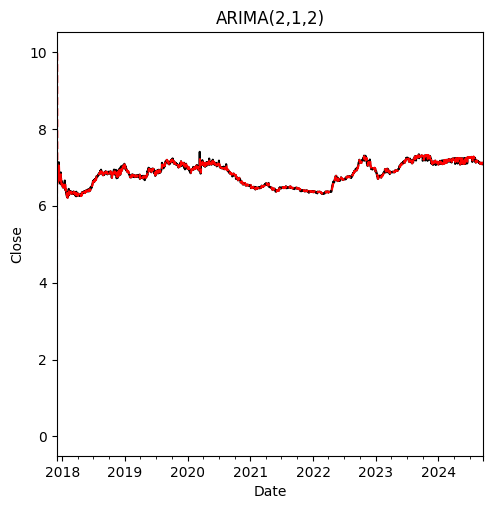

In [94]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
data['Close'].plot(color='k', linestyle = '-', ax=axarr)
data['ARIMA'].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(2,1,2)')
plt.xlabel('Date')
plt.ylabel('Close');

In [95]:
arima_obj = smtsa.ARIMA(data['Adj Close'].tolist(), order=(2, 1, 2))
arima_obj_fit = arima_obj.fit()
arima_obj_fit.summary()

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2484
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4914.493
Date:                Wed, 18 Sep 2024   AIC                          -9818.985
Time:                        17:43:56   BIC                          -9789.899
Sample:                             0   HQIC                         -9808.422
                               - 2484                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1843      0.635     -0.290      0.771      -1.428       1.059
ar.L2          0.0807      0.080      1.015      0.310      -0.075       0.237
ma.L1         -0.2310      0.635     -0.364      0.716      -1.475       1.013
ma.L2         -0.1989      0.338     -0.588      0.557      -0.862       0.464
sigma2         0.0011   8.71e-06    128.274      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             73829.99
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Análisis de residuos modelo ARIMA basado en el criterio AIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de Shapiro-Wilk y luego veamos gráficamente la distribución.

- Hipótesis Nula (H₀): La muestra parece provenir de una distribución normal.
- Hipótesis Alternativa (H₁): La muestra NO parece provenir de una distribución normal.

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Statistic = 0.084, p-value = 0.000


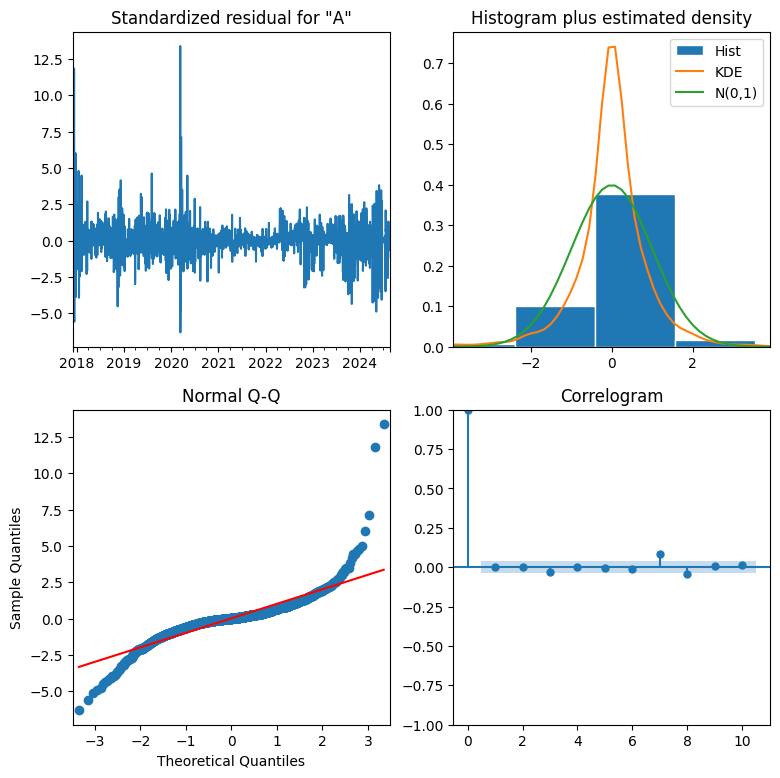

In [96]:
# Definir los parámetros p, d, q
p = 1  # por ejemplo, puedes cambiar estos valores según sea necesario
d = 1
q = 1

# Ajustar el modelo ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit_aic = model.fit()

# Luego puedes continuar con el diagnóstico
qq = model_fit_aic.plot_diagnostics(figsize=(9,9))

# Prueba de normalidad Shapiro-Wilk para los residuos del modelo
from scipy.stats import shapiro
stat, pvalue = shapiro(model_fit_aic.resid)
print(f'Statistic = {stat:.3f}, p-value = {pvalue:.3f}')



## **Criterio BIC**

### **Modelo ajustado**

In [97]:
best_order_bic = results['BIC']['best_order']
model_bic = ARIMA(train, order = best_order_bic)
model_fit_bic = model_bic.fit()

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


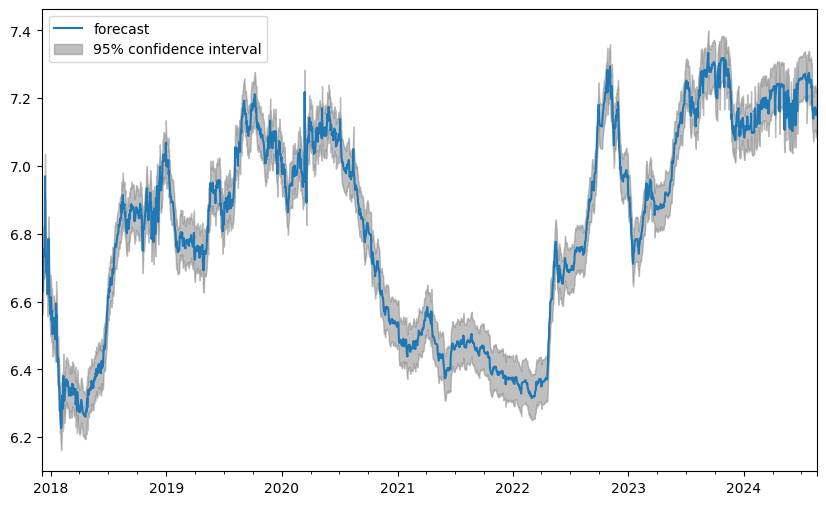

In [98]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Ajustar el tamaño de la gráfica
plt.rcParams.update({'figure.figsize': (10, 6)})

# Supongamos que 'model_fit_bic' es tu modelo ya ajustado (por ejemplo, ARIMA)
# El valor 2 significa que la predicción comienza en la segunda observación
plot_predict(model_fit_bic, start=2)

# Mostrar la gráfica
plt.show()


### **Análisis de residuos modelo ARIMA basado en el criterio BIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de Shapiro-Wilk y luego veamos gráficamente la distribución.

- Hipótesis Nula (H₀): La muestra parece provenir de una distribución normal.
- Hipótesis Alternativa (H₁): La muestra NO parece provenir de una distribución normal.

Statistic = 0.084
P-Value = 8.064205784568299e-76
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


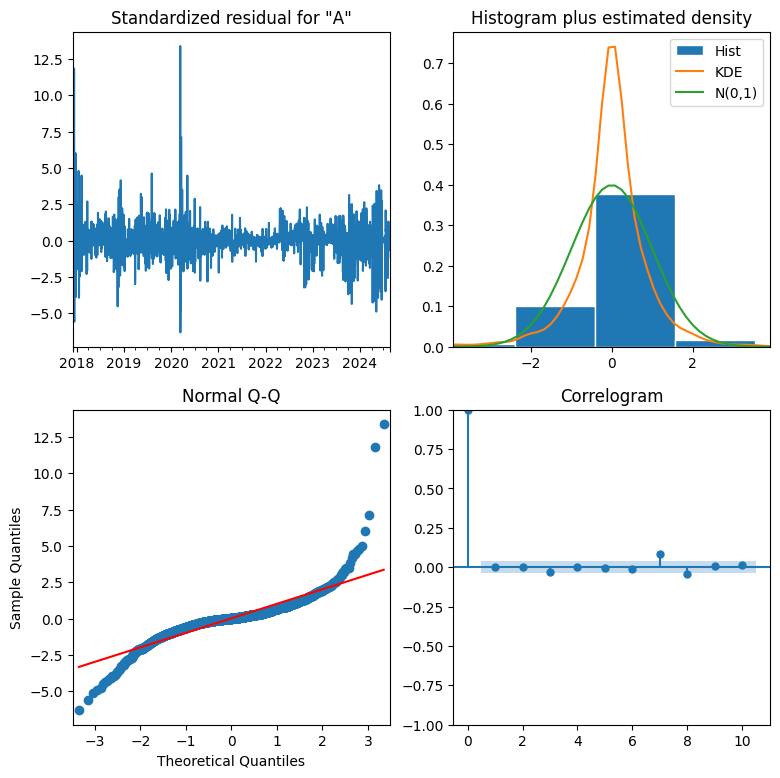

In [99]:
qq2 = model_fit_bic.plot_diagnostics(figsize=(9,9))

stat2, pvalue2 = shapiro(model_fit_bic.resid)
print(f'Statistic = {stat2:.3f}')
print(f'P-Value = {pvalue2}')
if(pvalue2 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')

## **Criterio HQIC**

### **Modelo ajustado**

In [100]:
best_order_hqic = results['HQIC']['best_order']
model_hqic = ARIMA(train, order = best_order_hqic)
model_fit_hqic = model_hqic.fit()

c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\envs\Vale\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

La siguiente gráfica representa la predicción realizada utilizando el modelo ARIMA ajustado al conjunto de datos de entrenamiento y al mejor orden obtenido para el criterio HQIC

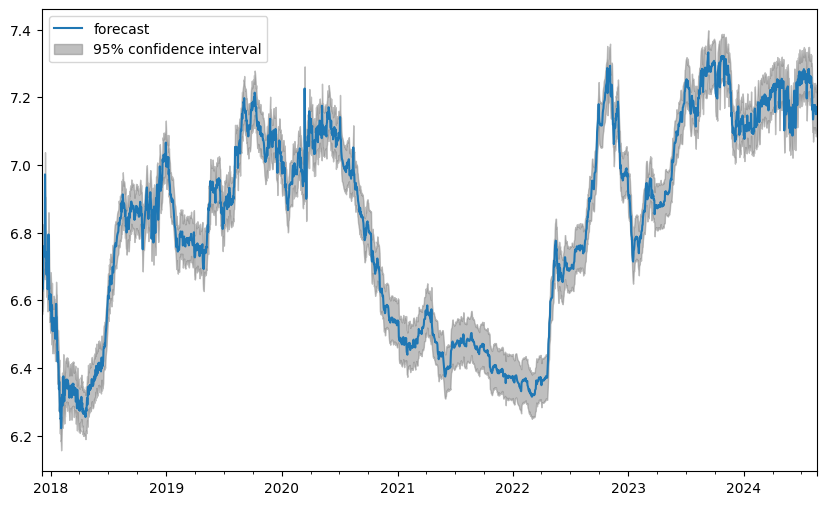

In [101]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(model_fit_hqic, 2);
# El valor 2 significa que la predicción comenzará desde la segunda observación.
plt.show();

### **Análisis de residuos modelo ARIMA basado en el criterio HQIC**

#### **Normalidad de los residuos**

Ahora, veamos la normalidad del conjunto de datos residuales por medio de la prueba de Shapiro-Wilk y luego veamos gráficamente la distribución.

- Hipótesis Nula (H₀): La muestra parece provenir de una distribución normal.
- Hipótesis Alternativa (H₁): La muestra NO parece provenir de una distribución normal.

Statistic = 0.824
P-Value = 7.593082117618287e-46
Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.


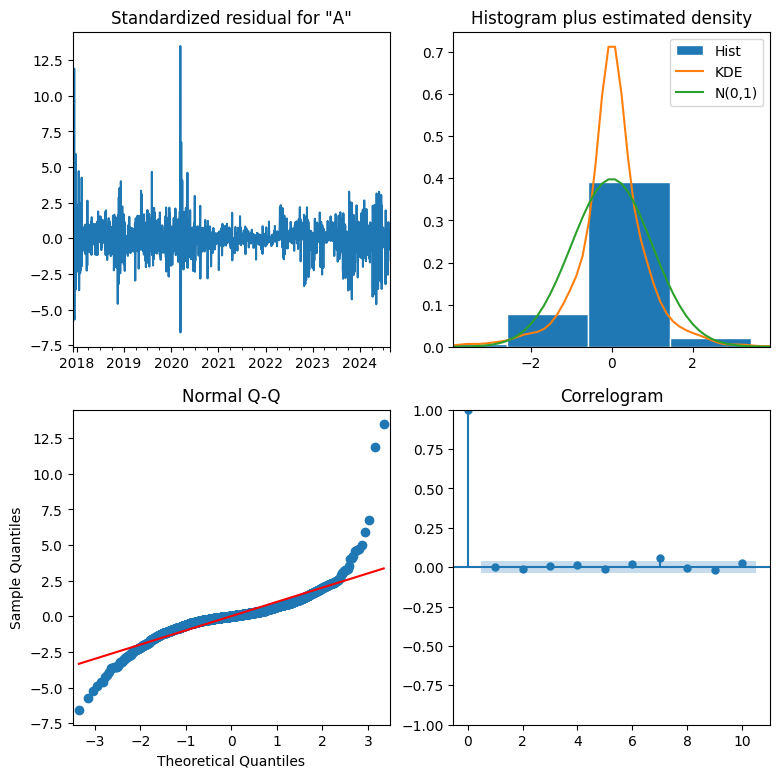

In [102]:
qq3 = model_fit_hqic.plot_diagnostics(figsize=(9,9))

stat3, pvalue3 = shapiro(model_fit_hqic.resid)
print(f'Statistic = {stat3:.3f}')
print(f'P-Value = {pvalue3}')
if(pvalue3 < 0.05):
    print('Se rechaza la hipótesis nula, por lo tanto los residuales no siguen una distribución normal.')
else:
    print('No se rechaza la hipótesis nula, por lo tanto los residuales siguen una distribución normal.')